# Fine-tunning Microsoft Git-base 

In [1]:
from datasets import load_dataset
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoProcessor, AutoModelForCausalLM, TrainingArguments, Trainer
from evaluate import load
import torch
import jiwer
from PIL import Image
import os
import sacrebleu
from pycocoevalcap.cider.cider import Cider

In [2]:
#"../data/indian_vehicles"
dataset = load_dataset("imagefolder", data_dir="../data/indian_vehicles")
print(dataset)
train_ds = dataset["train"]
test_ds = dataset["test"]

Resolving data files:   0%|          | 0/36 [00:00<?, ?it/s]

Found cached dataset imagefolder (/Users/avarela/.cache/huggingface/datasets/imagefolder/default-cb926d83aefffb34/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'additional_feature'],
        num_rows: 35
    })
    test: Dataset({
        features: ['image', 'additional_feature'],
        num_rows: 15
    })
})


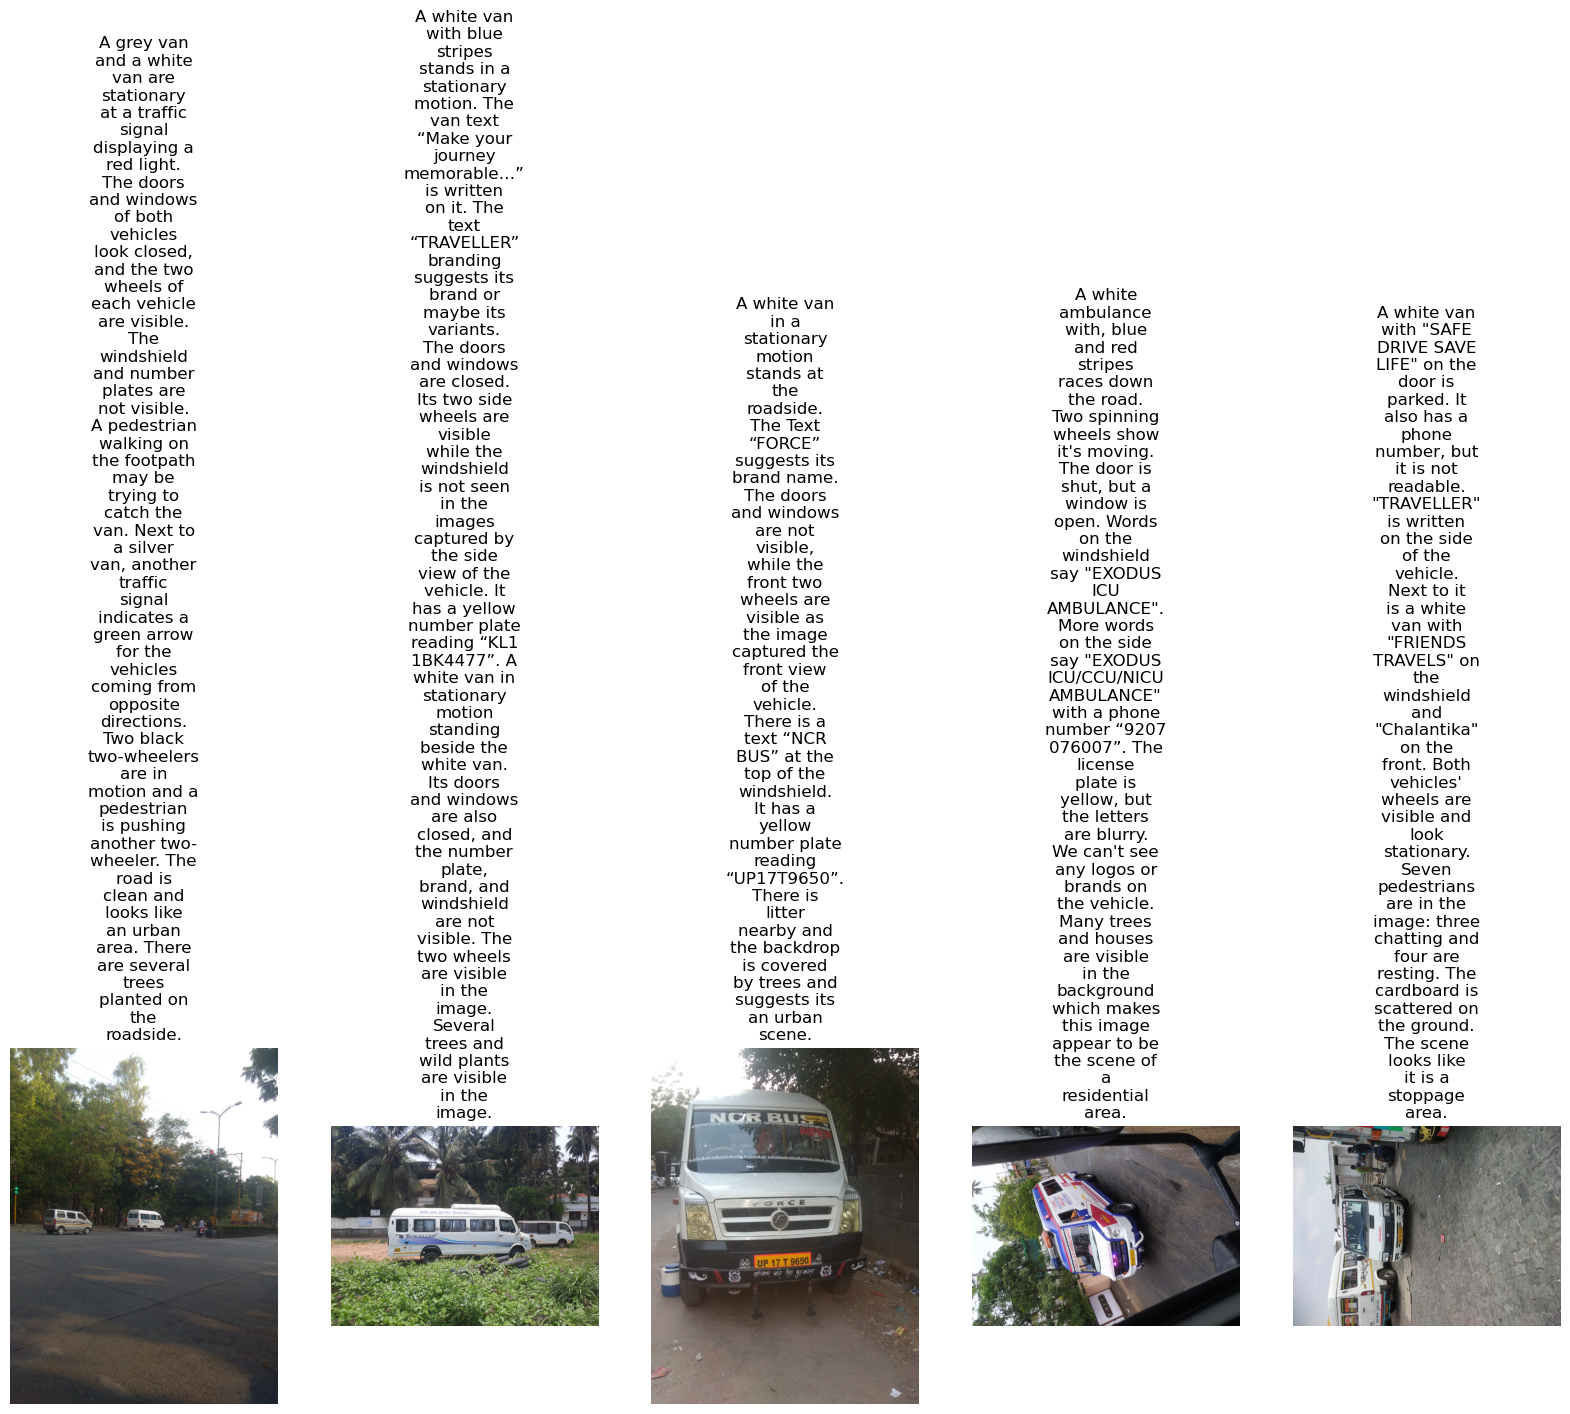

In [3]:
def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")


sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(5)]
sample_captions = [train_ds[i]["additional_feature"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

from transformers import AutoProcessor, AutoModelForMaskGeneration

processor = AutoProcessor.from_pretrained("facebook/sam-vit-base")
model = AutoModelForMaskGeneration.from_pretrained("facebook/sam-vit-base")

In [4]:
# Loading the processor which will resize the image and tokenize the caption
checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)

/Users/avarela/miniconda3/envs/torch-m1-mps/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["additional_feature"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs

# process train and test dataset
train_ds.set_transform(transforms)
test_ds.set_transform(transforms)
     

In [6]:
model = AutoModelForCausalLM.from_pretrained(checkpoint)
print(model)

GitForCausalLM(
  (git): GitModel(
    (embeddings): GitEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(1024, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (image_encoder): GitVisionModel(
      (vision_model): GitVisionTransformer(
        (embeddings): GitVisionEmbeddings(
          (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
          (position_embedding): Embedding(197, 768)
        )
        (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (encoder): GitVisionEncoder(
          (layers): ModuleList(
            (0-11): 12 x GitVisionEncoderLayer(
              (self_attn): GitVisionAttention(
                (k_proj): Linear(in_features=768, out_features=768, bias=True)
                (v_proj): Linear(in_features=768, out_features=768, bias=True)
             

In [21]:
#wer = load("wer")
# Define Word error Rate as a metric for image captioning 

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
#    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
#    return {"wer_score": wer_score}
    # Compute WER using jiwer-
    print(decoded_labels)
    print(decoded_predictions)
    wer_score = jiwer.wer(decoded_labels, decoded_predictions)
    # Computing CIDEr
    bleu_score = sacrebleu.corpus_bleu(decoded_predictions, [decoded_labels]).score / 100
    cider_score = Cider()
    gts = {idx:[ref] for idx, ref in enumerate(decoded_labels)}
    res = {idx:[pred] for idx,pred in enumerate(decoded_predictions)}
    cider_score, _ = cider_score.compute_score(gts, res)

    return {"wer_score": wer_score,
            "bleu": bleu_score, 
            "cider": cider_score}
     

# Define training arguments and trainer 

In [24]:
model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-indian_vehicles",
    learning_rate=2.5e-6,
    num_train_epochs=10,
    fp16=False,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=2,
    save_total_limit=3,
    evaluation_strategy="steps",
    eval_steps=10,
    save_strategy="steps",
    save_steps=10,
    logging_steps=10,
    remove_unused_columns=False,
    label_names=["labels"],
    load_best_model_at_end=True,
    report_to=[]
)





trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)
     

model_name = checkpoint.split("/")[1]
training_args = TrainingArguments(
    output_dir=f"{model_name}-indian_vehicles",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_steps=10,
    num_train_epochs=1,
    evaluation_strategy="epoch"
    )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

In [25]:
trainer.train()

/Users/avarela/miniconda3/envs/torch-m1-mps/lib/python3.11/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/90 [00:00<?, ?it/s]

{'loss': 0.7324, 'learning_rate': 2.222222222222222e-06, 'epoch': 1.11}


  0%|          | 0/8 [00:00<?, ?it/s]

['a white car with closed doors and windows, its number plate is invisible, sits parked. a beige bus with the text " kusmara shanti " and the number plate " up75m3259 " travels down the street, its windows open while the doors remain closed and a rear wheel is visible. across the street, another white car with plate " up75t6636 " is also parked. the surrounding buildings, trees, and people suggest a bustling urban environment.', 'a white car with closed doors is parked on the left side of the road, but its number plate is invisible. a red two - wheeler is also parked nearby on the sidewalk, without a visible plate. on the street, a white bus with " skyline " written on it travels with open doors and windows, revealing passengers inside. there is no visible logo but the wheels of the vehicle are visible. a pedestrian stands on the bus steps. buildings, trees, and people in the background create a busy urban scene', "a white bus with closed doors and windows, lacking a visible license pl

  0%|          | 0/8 [00:00<?, ?it/s]

['a white car with closed doors and windows, its number plate is invisible, sits parked. a beige bus with the text " kusmara shanti " and the number plate " up75m3259 " travels down the street, its windows open while the doors remain closed and a rear wheel is visible. across the street, another white car with plate " up75t6636 " is also parked. the surrounding buildings, trees, and people suggest a bustling urban environment.', 'a white car with closed doors is parked on the left side of the road, but its number plate is invisible. a red two - wheeler is also parked nearby on the sidewalk, without a visible plate. on the street, a white bus with " skyline " written on it travels with open doors and windows, revealing passengers inside. there is no visible logo but the wheels of the vehicle are visible. a pedestrian stands on the bus steps. buildings, trees, and people in the background create a busy urban scene', "a white bus with closed doors and windows, lacking a visible license pl

  0%|          | 0/8 [00:00<?, ?it/s]

['a white car with closed doors and windows, its number plate is invisible, sits parked. a beige bus with the text " kusmara shanti " and the number plate " up75m3259 " travels down the street, its windows open while the doors remain closed and a rear wheel is visible. across the street, another white car with plate " up75t6636 " is also parked. the surrounding buildings, trees, and people suggest a bustling urban environment.', 'a white car with closed doors is parked on the left side of the road, but its number plate is invisible. a red two - wheeler is also parked nearby on the sidewalk, without a visible plate. on the street, a white bus with " skyline " written on it travels with open doors and windows, revealing passengers inside. there is no visible logo but the wheels of the vehicle are visible. a pedestrian stands on the bus steps. buildings, trees, and people in the background create a busy urban scene', "a white bus with closed doors and windows, lacking a visible license pl

  0%|          | 0/8 [00:00<?, ?it/s]

['a white car with closed doors and windows, its number plate is invisible, sits parked. a beige bus with the text " kusmara shanti " and the number plate " up75m3259 " travels down the street, its windows open while the doors remain closed and a rear wheel is visible. across the street, another white car with plate " up75t6636 " is also parked. the surrounding buildings, trees, and people suggest a bustling urban environment.', 'a white car with closed doors is parked on the left side of the road, but its number plate is invisible. a red two - wheeler is also parked nearby on the sidewalk, without a visible plate. on the street, a white bus with " skyline " written on it travels with open doors and windows, revealing passengers inside. there is no visible logo but the wheels of the vehicle are visible. a pedestrian stands on the bus steps. buildings, trees, and people in the background create a busy urban scene', "a white bus with closed doors and windows, lacking a visible license pl

  0%|          | 0/8 [00:00<?, ?it/s]

['a white car with closed doors and windows, its number plate is invisible, sits parked. a beige bus with the text " kusmara shanti " and the number plate " up75m3259 " travels down the street, its windows open while the doors remain closed and a rear wheel is visible. across the street, another white car with plate " up75t6636 " is also parked. the surrounding buildings, trees, and people suggest a bustling urban environment.', 'a white car with closed doors is parked on the left side of the road, but its number plate is invisible. a red two - wheeler is also parked nearby on the sidewalk, without a visible plate. on the street, a white bus with " skyline " written on it travels with open doors and windows, revealing passengers inside. there is no visible logo but the wheels of the vehicle are visible. a pedestrian stands on the bus steps. buildings, trees, and people in the background create a busy urban scene', "a white bus with closed doors and windows, lacking a visible license pl

  0%|          | 0/8 [00:00<?, ?it/s]

['a white car with closed doors and windows, its number plate is invisible, sits parked. a beige bus with the text " kusmara shanti " and the number plate " up75m3259 " travels down the street, its windows open while the doors remain closed and a rear wheel is visible. across the street, another white car with plate " up75t6636 " is also parked. the surrounding buildings, trees, and people suggest a bustling urban environment.', 'a white car with closed doors is parked on the left side of the road, but its number plate is invisible. a red two - wheeler is also parked nearby on the sidewalk, without a visible plate. on the street, a white bus with " skyline " written on it travels with open doors and windows, revealing passengers inside. there is no visible logo but the wheels of the vehicle are visible. a pedestrian stands on the bus steps. buildings, trees, and people in the background create a busy urban scene', "a white bus with closed doors and windows, lacking a visible license pl

  0%|          | 0/8 [00:00<?, ?it/s]

['a white car with closed doors and windows, its number plate is invisible, sits parked. a beige bus with the text " kusmara shanti " and the number plate " up75m3259 " travels down the street, its windows open while the doors remain closed and a rear wheel is visible. across the street, another white car with plate " up75t6636 " is also parked. the surrounding buildings, trees, and people suggest a bustling urban environment.', 'a white car with closed doors is parked on the left side of the road, but its number plate is invisible. a red two - wheeler is also parked nearby on the sidewalk, without a visible plate. on the street, a white bus with " skyline " written on it travels with open doors and windows, revealing passengers inside. there is no visible logo but the wheels of the vehicle are visible. a pedestrian stands on the bus steps. buildings, trees, and people in the background create a busy urban scene', "a white bus with closed doors and windows, lacking a visible license pl

  0%|          | 0/8 [00:00<?, ?it/s]

['a white car with closed doors and windows, its number plate is invisible, sits parked. a beige bus with the text " kusmara shanti " and the number plate " up75m3259 " travels down the street, its windows open while the doors remain closed and a rear wheel is visible. across the street, another white car with plate " up75t6636 " is also parked. the surrounding buildings, trees, and people suggest a bustling urban environment.', 'a white car with closed doors is parked on the left side of the road, but its number plate is invisible. a red two - wheeler is also parked nearby on the sidewalk, without a visible plate. on the street, a white bus with " skyline " written on it travels with open doors and windows, revealing passengers inside. there is no visible logo but the wheels of the vehicle are visible. a pedestrian stands on the bus steps. buildings, trees, and people in the background create a busy urban scene', "a white bus with closed doors and windows, lacking a visible license pl

  0%|          | 0/8 [00:00<?, ?it/s]

['a white car with closed doors and windows, its number plate is invisible, sits parked. a beige bus with the text " kusmara shanti " and the number plate " up75m3259 " travels down the street, its windows open while the doors remain closed and a rear wheel is visible. across the street, another white car with plate " up75t6636 " is also parked. the surrounding buildings, trees, and people suggest a bustling urban environment.', 'a white car with closed doors is parked on the left side of the road, but its number plate is invisible. a red two - wheeler is also parked nearby on the sidewalk, without a visible plate. on the street, a white bus with " skyline " written on it travels with open doors and windows, revealing passengers inside. there is no visible logo but the wheels of the vehicle are visible. a pedestrian stands on the bus steps. buildings, trees, and people in the background create a busy urban scene', "a white bus with closed doors and windows, lacking a visible license pl

TrainOutput(global_step=90, training_loss=0.6775925053490532, metrics={'train_runtime': 1192.6372, 'train_samples_per_second': 0.293, 'train_steps_per_second': 0.075, 'train_loss': 0.6775925053490532, 'epoch': 10.0})

In [26]:
# Evaluate the model
results = trainer.evaluate()

# Print evaluation results
print("Evaluation Results:", results)


  0%|          | 0/8 [00:00<?, ?it/s]

['a white car with closed doors and windows, its number plate is invisible, sits parked. a beige bus with the text " kusmara shanti " and the number plate " up75m3259 " travels down the street, its windows open while the doors remain closed and a rear wheel is visible. across the street, another white car with plate " up75t6636 " is also parked. the surrounding buildings, trees, and people suggest a bustling urban environment.', 'a white car with closed doors is parked on the left side of the road, but its number plate is invisible. a red two - wheeler is also parked nearby on the sidewalk, without a visible plate. on the street, a white bus with " skyline " written on it travels with open doors and windows, revealing passengers inside. there is no visible logo but the wheels of the vehicle are visible. a pedestrian stands on the bus steps. buildings, trees, and people in the background create a busy urban scene', "a white bus with closed doors and windows, lacking a visible license pl

In [27]:
# Get the predictions of the test dataset 
eval_preds = trainer.predict(test_ds)

# Extract logits and other outputs
logits = eval_preds.predictions
labels = eval_preds.label_ids  # True labels
metrics = eval_preds.metrics  # Evaluation metrics like accuracy


  0%|          | 0/8 [00:00<?, ?it/s]

['a white car with closed doors and windows, its number plate is invisible, sits parked. a beige bus with the text " kusmara shanti " and the number plate " up75m3259 " travels down the street, its windows open while the doors remain closed and a rear wheel is visible. across the street, another white car with plate " up75t6636 " is also parked. the surrounding buildings, trees, and people suggest a bustling urban environment.', 'a white car with closed doors is parked on the left side of the road, but its number plate is invisible. a red two - wheeler is also parked nearby on the sidewalk, without a visible plate. on the street, a white bus with " skyline " written on it travels with open doors and windows, revealing passengers inside. there is no visible logo but the wheels of the vehicle are visible. a pedestrian stands on the bus steps. buildings, trees, and people in the background create a busy urban scene', "a white bus with closed doors and windows, lacking a visible license pl

In [28]:
print(logits)
print(labels)
print(metrics)

[[[ 2.4456027  -1.1976998  -1.1981772  ... -1.197398   -1.1980368
   -1.1969692 ]
  [ 2.6081083  -1.462805   -1.4639257  ... -1.4621453  -1.463476
   -1.4612863 ]
  [ 3.698703   -1.1057832  -1.1080372  ... -1.104364   -1.1075536
   -1.1025265 ]
  ...
  [ 7.930264   -1.945715   -1.9504998  ... -1.943012   -1.9492888
   -1.938953  ]
  [ 7.9403877  -1.9367801  -1.9415623  ... -1.9340742  -1.9403495
   -1.9300176 ]
  [ 7.92519    -1.9448949  -1.9497328  ... -1.942168   -1.9485053
   -1.9380686 ]]

 [[ 3.7668562  -1.2225604  -1.2238857  ... -1.2217218  -1.2235799
   -1.2205719 ]
  [ 3.9890015  -1.2015424  -1.2036405  ... -1.2002969  -1.2032026
   -1.1984459 ]
  [ 5.2336445  -1.3070452  -1.3092179  ... -1.3059138  -1.3086815
   -1.3038993 ]
  ...
  [ 7.93836    -1.9372323  -1.9420047  ... -1.9345353  -1.9408004
   -1.9304907 ]
  [ 7.9491944  -1.9249725  -1.9297391  ... -1.9222801  -1.9285351
   -1.9182379 ]
  [ 7.934453   -1.9335836  -1.938423   ... -1.9308565  -1.9371948
   -1.9267598 ]]

 

In [29]:
image_path = "../data/indian_vehicles/test/dc_vehicle_captions_000036_hCuPJAUp.jpg"  # replace with your image path
image = Image.open(image_path) 
image = image.convert("RGB") 

# Check the image format
print(f"Image format: {image.format}, size: {image.size}, mode: {image.mode}")


Image format: None, size: (3000, 4000), mode: RGB


a white bus with closed doors and windows is parked on the side of the road. the text " tourist " is riding at the bottom of the signboard. the windshield is visible but the the windshield is a two - wheeler is a pedestrian is


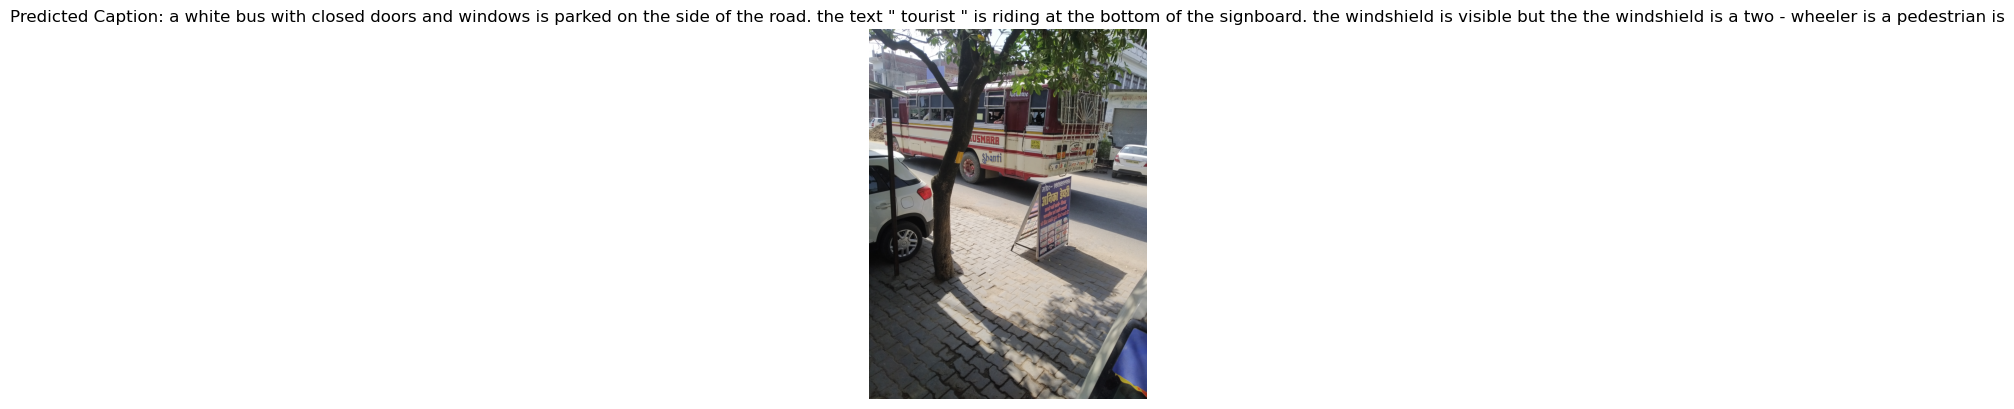

In [30]:
# Pass just one example 
inputs = processor(images=image, return_tensors="pt")
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values = pixel_values, max_length = 50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens = True)[0]
print(generated_caption)


plt.imshow(image)
plt.axis('off') 
plt.title(f"Predicted Caption: {generated_caption}")
plt.show()

Processing image: dc_vehicle_captions_000039_OqtajU84.jpg
a grey van with closed doors and windows is parked. the text on the side of the vehicle is not readable. the number plate is not readable. the number plate or logo suggests its two side wheels are visible. a pedestrian is riding


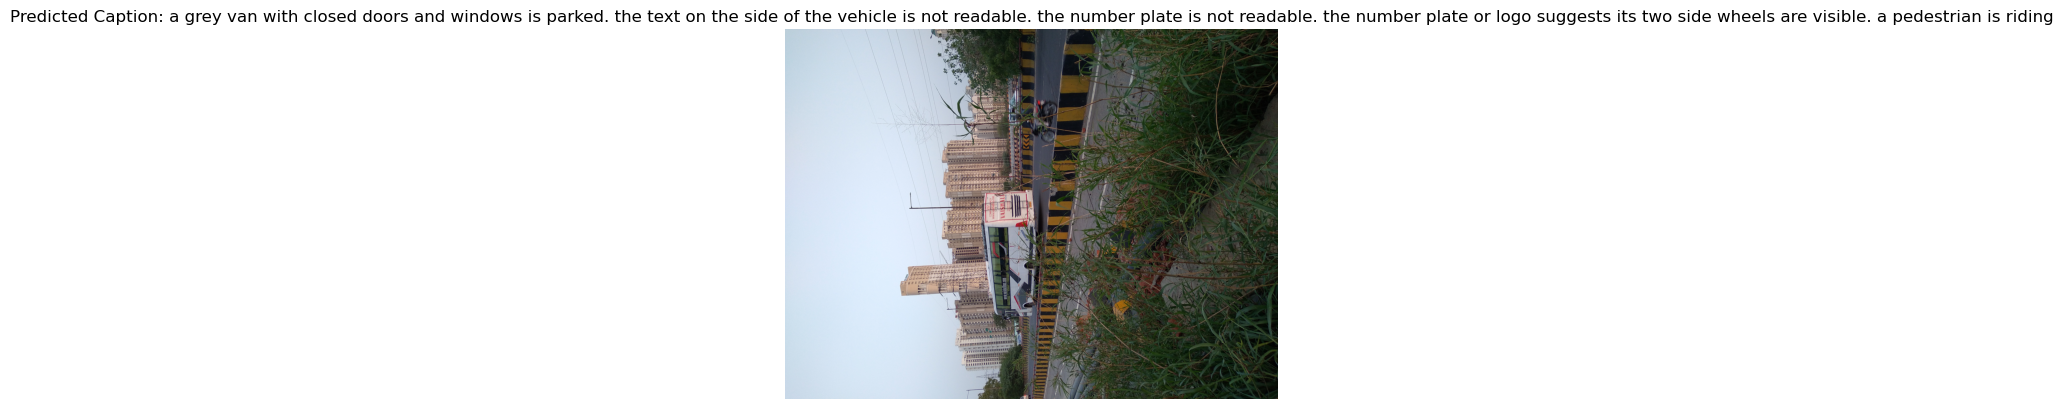

Processing image: dc_vehicle_captions_000038_kn1EBqel.jpg
a white ambulance speeds down the center of a street. its doors are closed, but the number plate is not visible. the text on the vehicle says " tourist " is written on the side of the vehicle. the vehicle. the number plate is


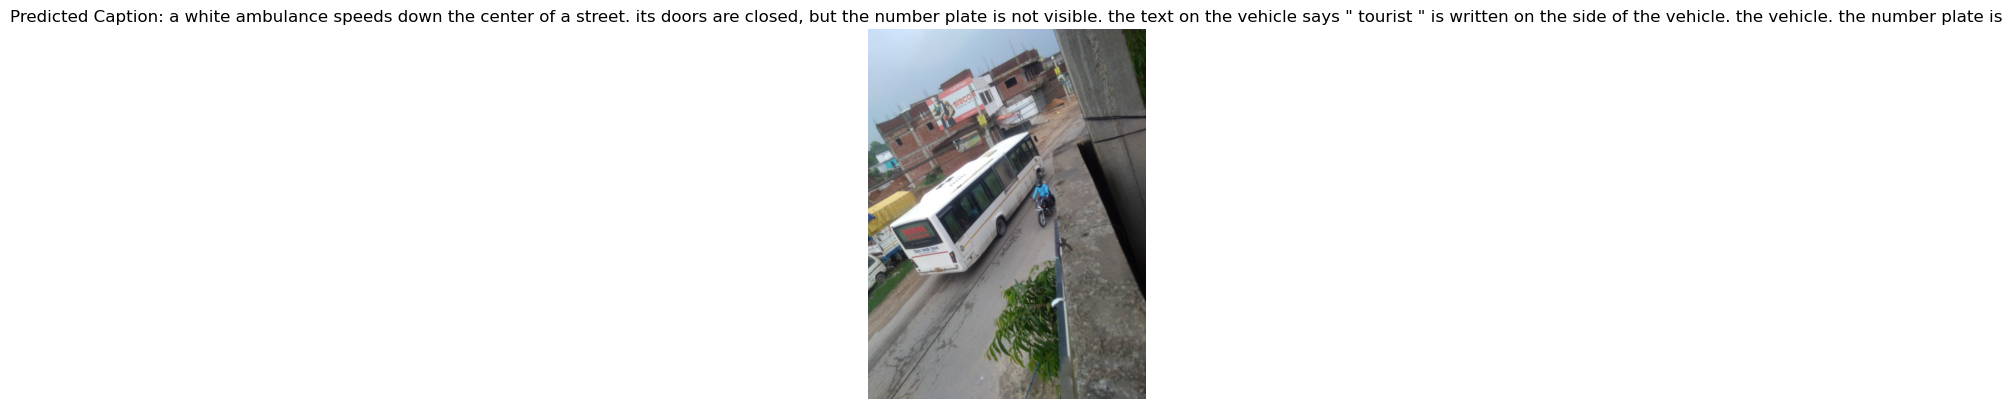

Processing image: dc_vehicle_captions_000036_hCuPJAUp.jpg
a white bus with closed doors and windows is parked on the side of the road. the text " tourist " is riding at the bottom of the signboard. the windshield is visible but the the windshield is a two - wheeler is a pedestrian is


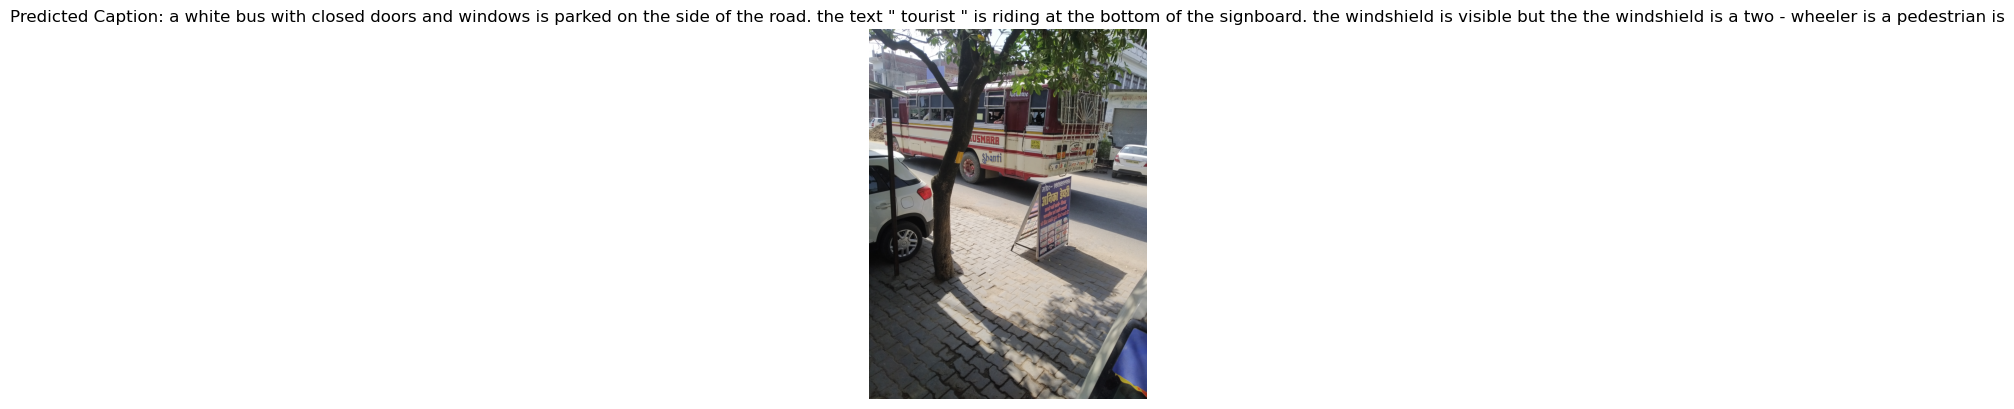

Processing image: dc_vehicle_captions_000043_jJHLAmBc.jpg
a black two - wheeler with a number plate reading " up84ac6425 and two visible wheels is parked on the side of the road. a grey van with closed doors and a visible windshield and open windows is moving. a pedestrian


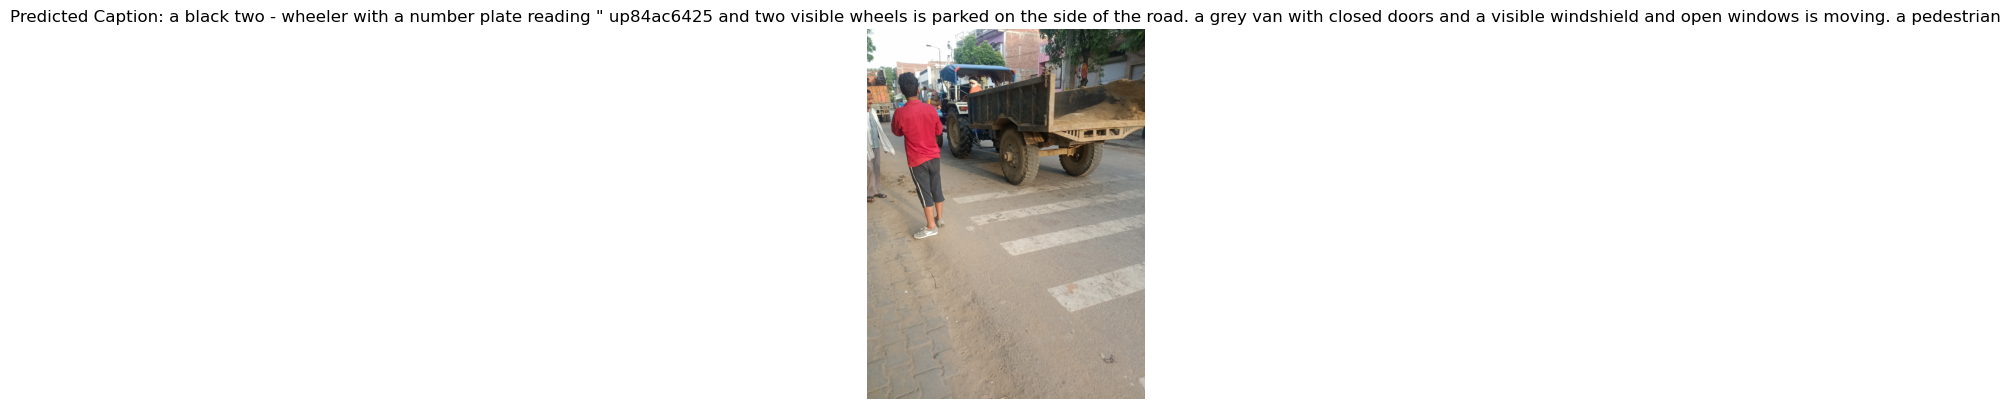

Processing image: dc_vehicle_captions_000050_tt1bkXeF.jpg
a red truck with the number plate " up84ac642504 " is parked on the side of the road. the white ambulance is parked on the left side of the road and the bus with the windshield is a white car is


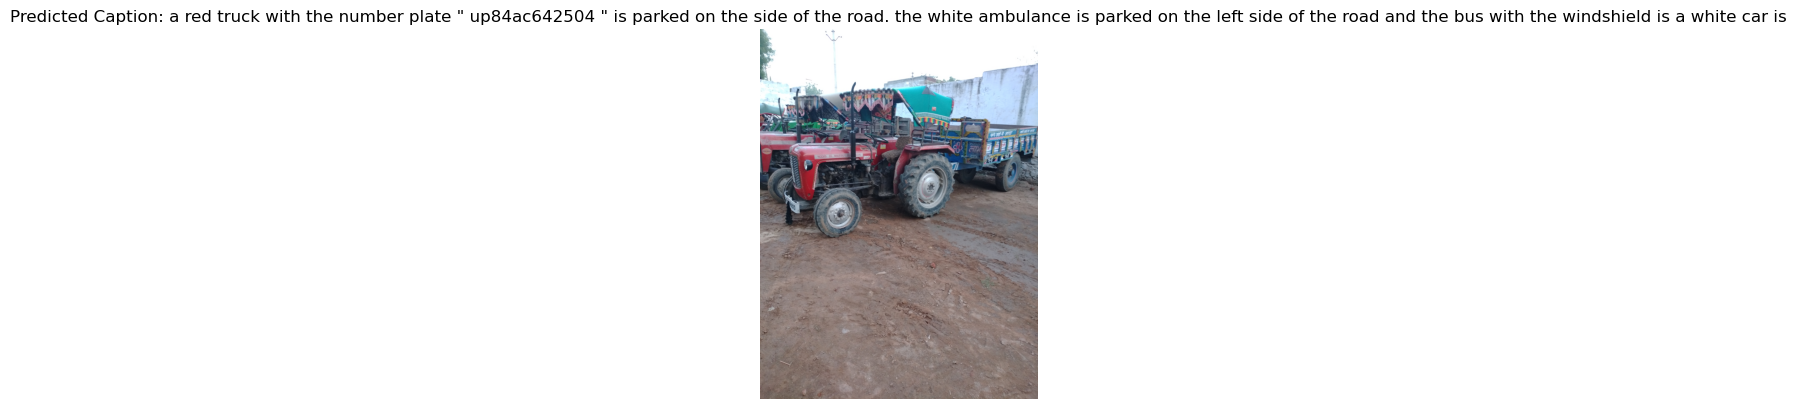

Processing image: dc_vehicle_captions_000049_7YBkuNKH.jpg
a white van with the number plate " up84 " is parked next to a tree. the text on the door is open, and the number plate is not readable. the text the number plate is not readable. the text


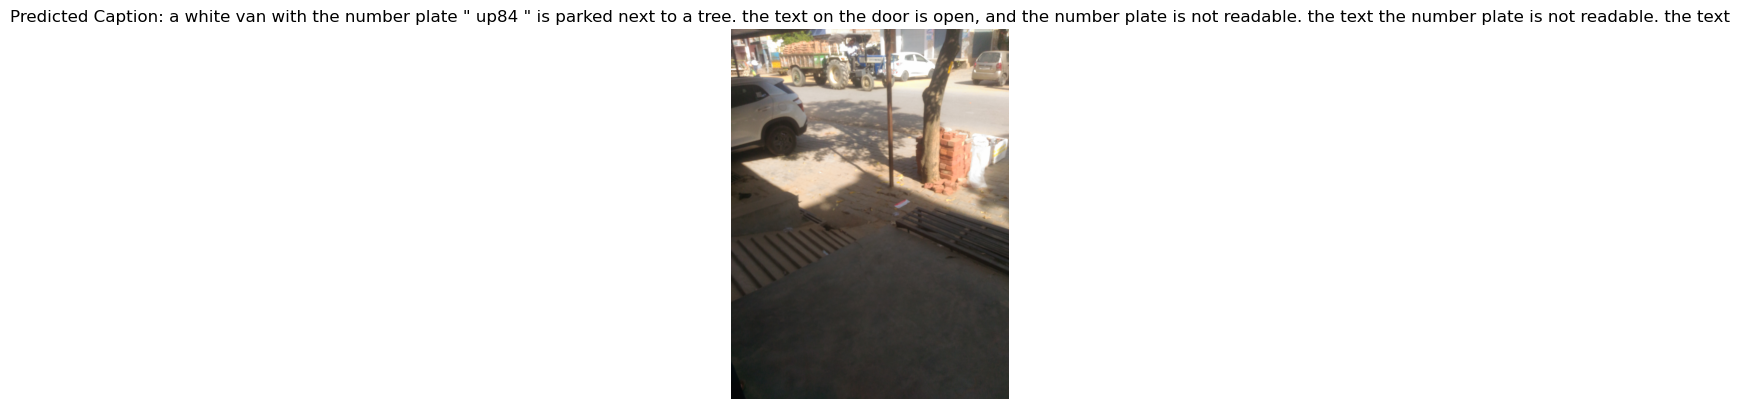

Processing image: dc_vehicle_captions_000041_31An12C4.jpg
a black two - wheeler with a number plate reading up84ac6425 and two visible wheels is parked on the sidewalk. a brown cow ambles across the street, and the street, a white van with closed doors and windows


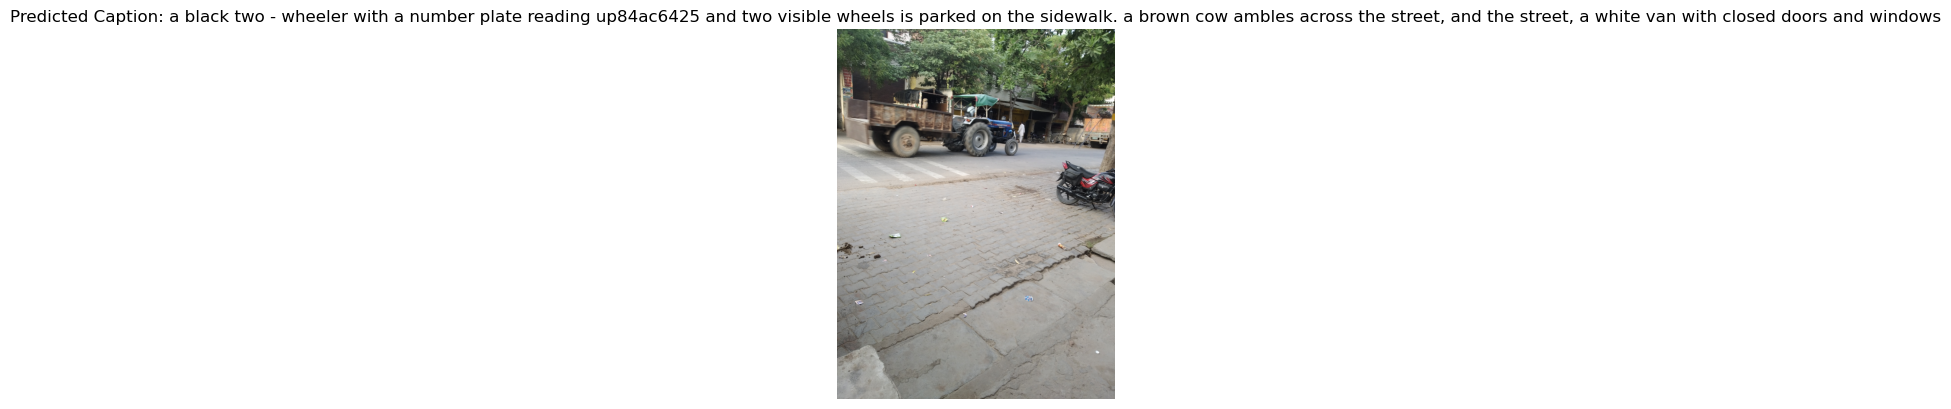

Processing image: dc_vehicle_captions_000042_LB4BeVDe.jpg
a blue van with closed doors and windows is parked. the text " kl84ac642506sa3576 " is written on the side is written on the side of the side is a white van. the side is


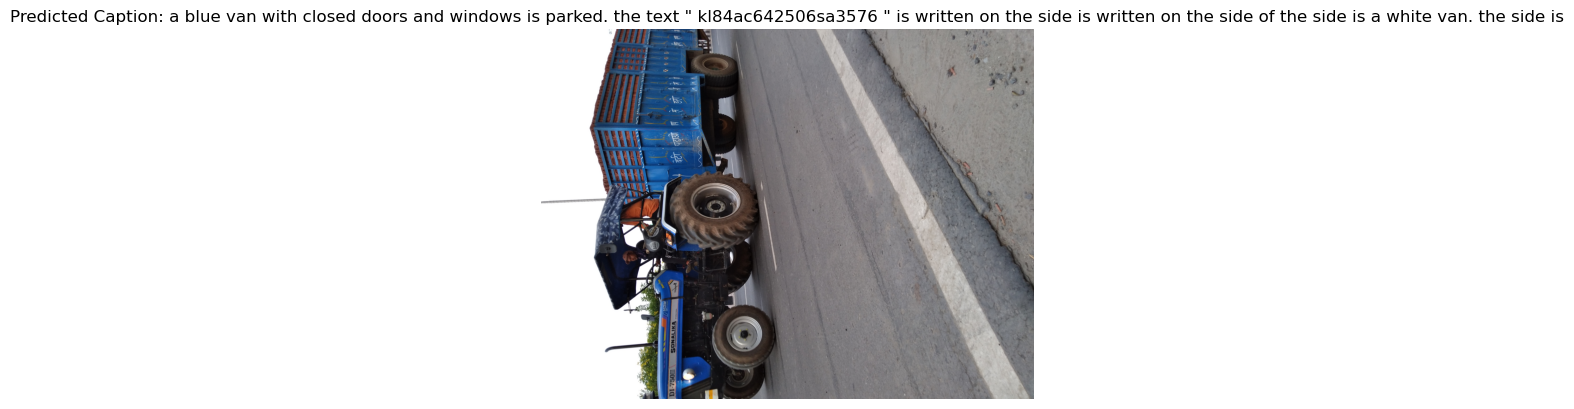

Processing image: dc_vehicle_captions_000045_YPZiP8Y0.jpg
a white ambulance with blue stripes is parked under a tree. its doors are closed, but the number plate is not visible. the text on the windshield and windows are not visible. a white visible. a pedestrian is a white ambulance " tourist "


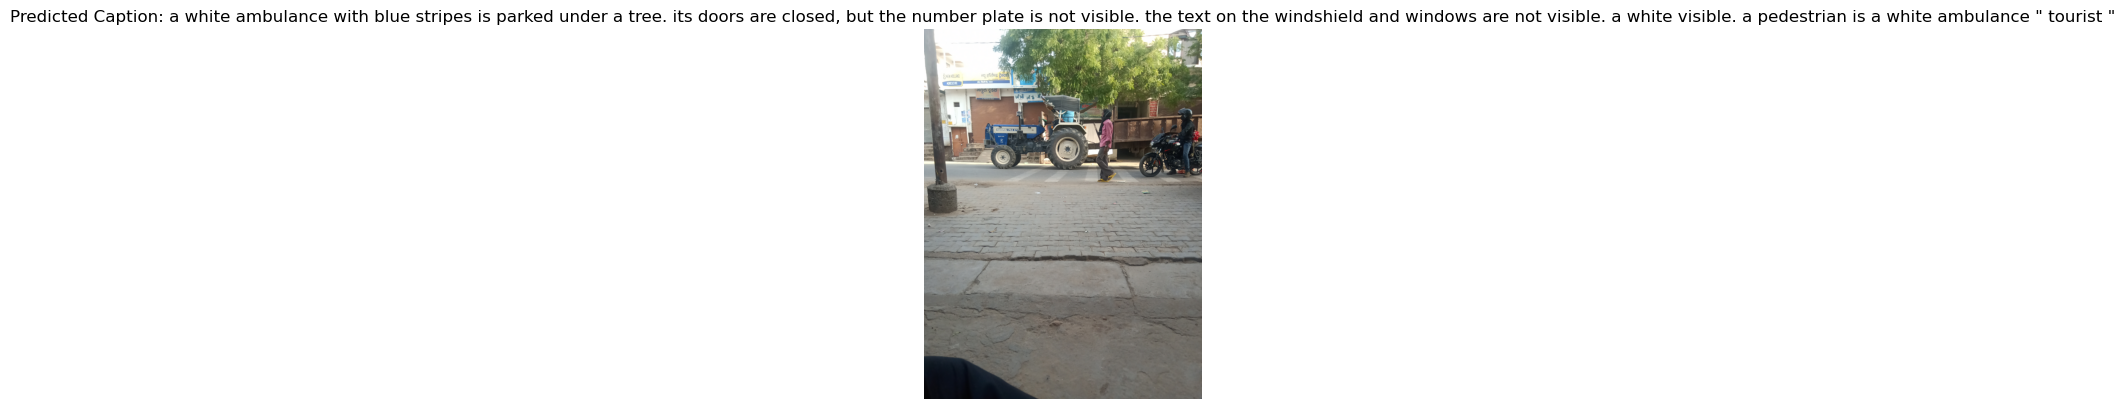

Processing image: dc_vehicle_captions_000046_jlB405Y6.jpg
a black two - wheeler with a number plate reading up84ac6425 and two visible wheels is parked on the side of the road. a white car is parked on the the side, a grey van. a white car is


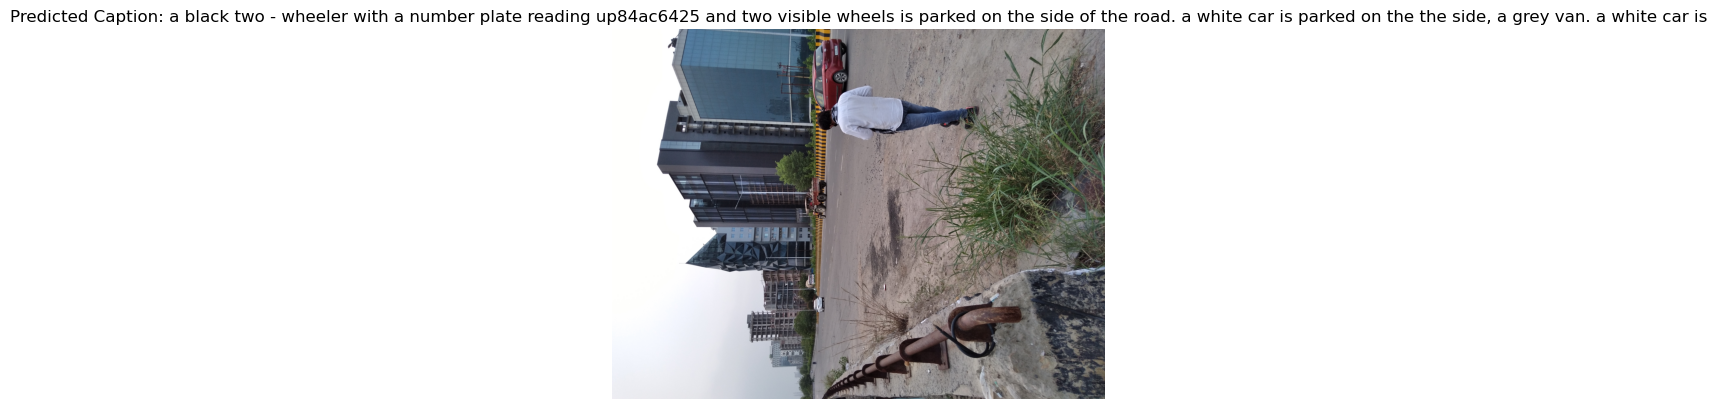

Processing image: dc_vehicle_captions_000040_nup4PwVq.jpg
a white van with the text written on its windows are closed doors and windows and doors and doors and windows are closed. the text on the side is not visible but the the windshield. the windshield is not visible. the text


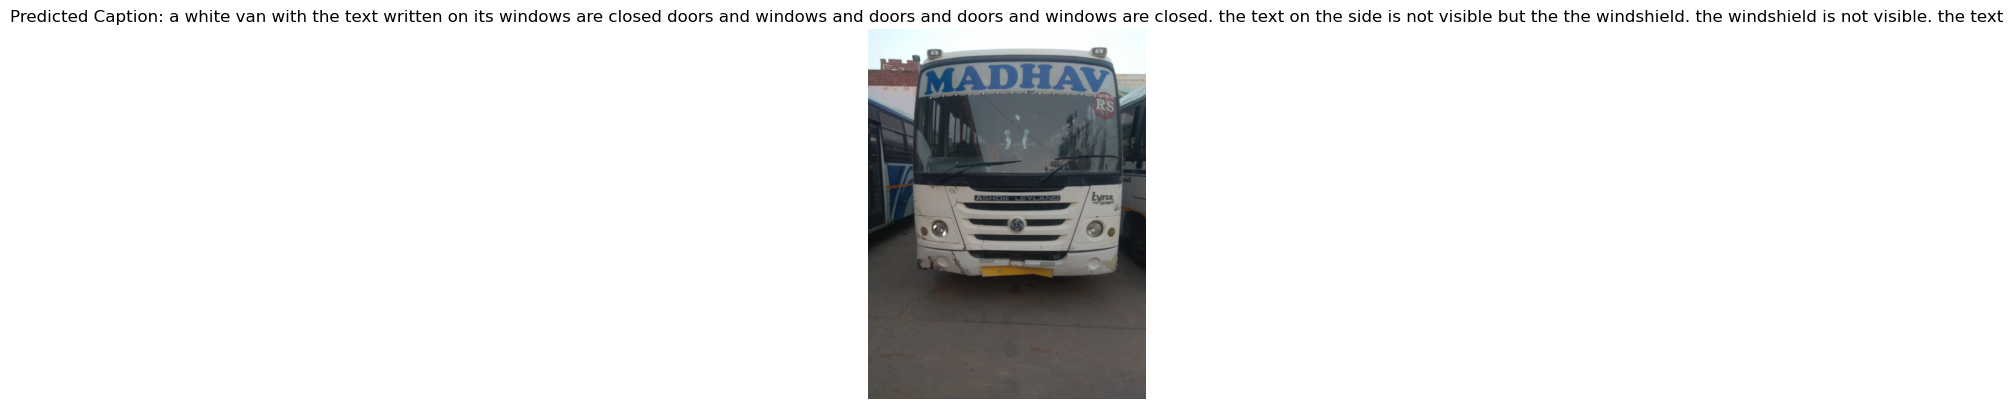

Processing image: dc_vehicle_captions_000048_QHPqX4Kv.jpg
a grey van with closed doors and windows is parked under a tree. the number plate is not readable. the number plate is not readable. the number plate is written on the windshield and the number plate. a white two - wheeler is


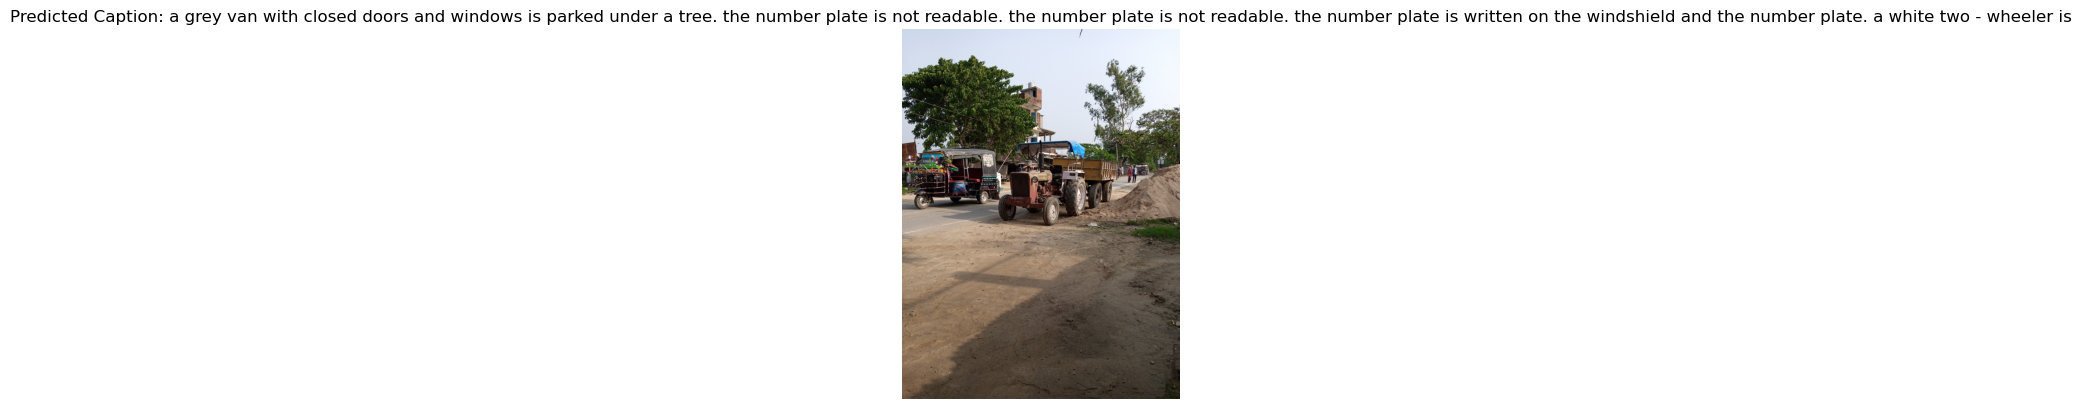

Processing image: dc_vehicle_captions_000037_pndhqAQg.jpg
a white van with closed doors and windows is parked under a tree. the text on the windshield is not visible but a bicycle is visible but the number plate reading " up84sa1717b1207777721.


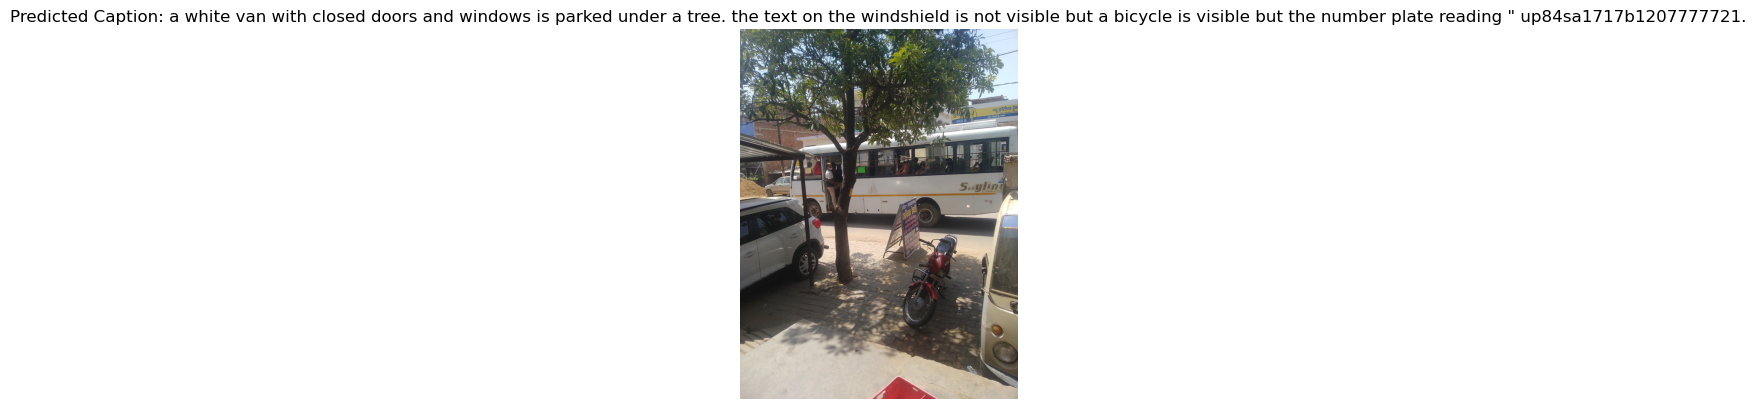

Processing image: dc_vehicle_captions_000047_xLL0akZh.jpg
a blue two - wheeler with a number plate reading up84ac6425 and two visible wheels is parked under a tree. a white car with closed doors and windows is parked and windows with closed, a pedestrian walks on the sidewalk


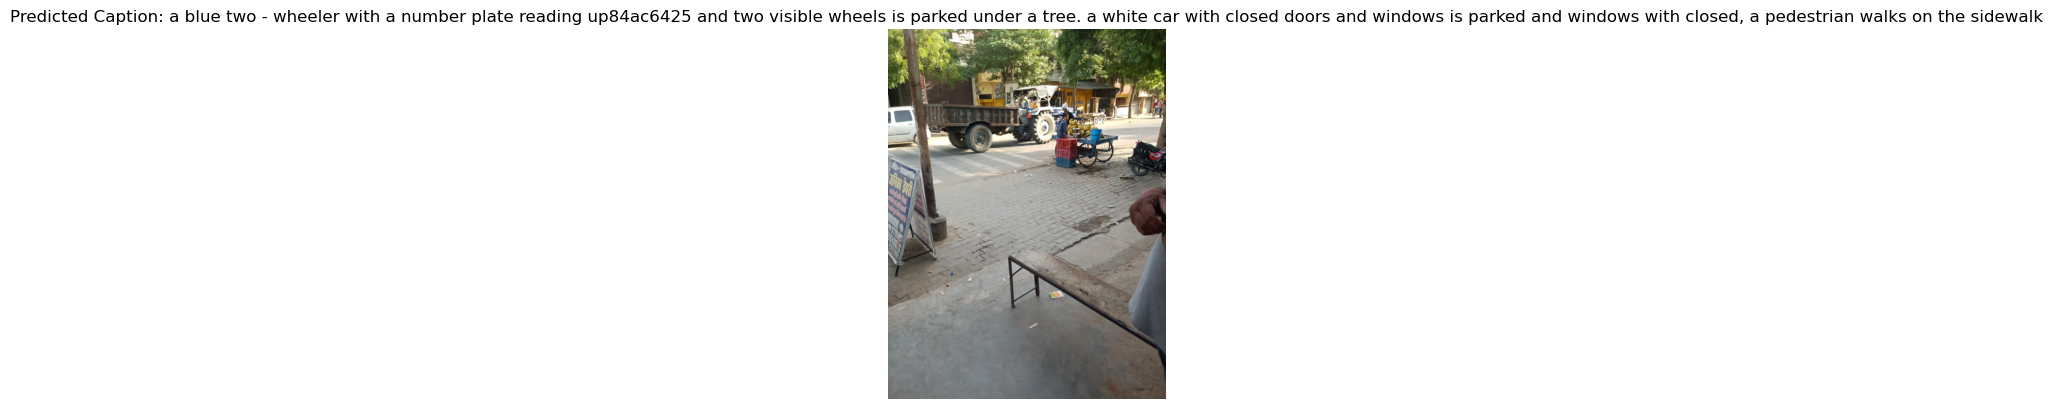

Processing image: dc_vehicle_captions_000044_5OXmnXqS.jpg
a blue motorcycle with a number plate reading " up84ac642504ac6425, and a white ambulance with closed doors and windows is parked on the side of the the road. a white truck is parked under a tree


In [31]:
image_dir = "../data/indian_vehicles/test/"  

for filename in os.listdir(image_dir):
    # Check if the file is an image (you can adjust this to include other formats if needed)
    if filename.lower().endswith(('.jpg')):
        image_path = os.path.join(image_dir, filename)  # full path to the image
        print(f"Processing image: {filename}")
        image = Image.open(image_path)
        image = image.convert("RGB")  

        # Preprocess the image
        inputs = processor(images=image, return_tensors="pt")
        pixel_values = inputs.pixel_values

        generated_ids = model.generate(pixel_values = pixel_values, max_length = 50)
        generated_caption = processor.batch_decode(generated_ids, skip_special_tokens = True)[0]
        print(generated_caption)


        plt.imshow(image)
        plt.axis('off') 
        plt.title(f"Predicted Caption: {generated_caption}")
        plt.show() 